In [312]:
%matplotlib inline
import matplotlib.pyplot as plt
from ttvfast import ttvfast
from ttvfast.models import Planet 
from astropy.constants import M_sun, M_earth
import numpy as np
import astropy.units as u

midtransit_f = 2455422.710
midtransit_e = 2454983.404
period_f = 267.291
period_e = 122.3874

# phase = 360 * (midtransit_f - midtransit_e)/period_e % 1

# mass_e = 4.45356410231 * float(M_earth/M_sun) # Forecaster (Berger 2018, Chen+ 2017)
# mass_f = 3.33116078749 * float(M_earth/M_sun) # Forecaster (Berger 2018, Chen+ 2017)

# e = Planet(mass=mass_e, period=period_e, eccentricity=0, inclination=89.98, 
#            longnode=90, argument=90, mean_anomaly=0)
# f = Planet(mass=mass_f, period=period_f, eccentricity=0, inclination=89.90, 
#            longnode=90, argument=90, mean_anomaly=phase)

In [313]:
observed_timing = np.loadtxt("../libra/data/timing_k62_Kep_HST.txt", delimiter=',')

In [314]:
timing_e = observed_timing[observed_timing[:, 0] == 1][:, -3:]
timing_f = observed_timing[observed_timing[:, 0] == 2][:, -3:]

timing_e[:, 1] += 2450000
timing_f[:, 1] += 2450000

epochs_e, times_e, errs_e = timing_e.T
epochs_f, times_f, errs_f = timing_f.T

<ErrorbarContainer object of 3 artists>

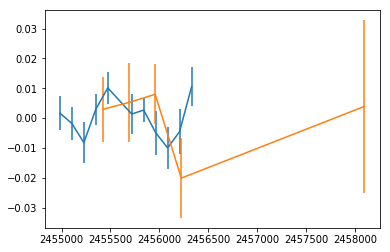

In [315]:
plt.errorbar(times_e, times_e - np.polyval(np.polyfit(epochs_e, times_e, 1), epochs_e), errs_e)
plt.errorbar(times_f, times_f - np.polyval(np.polyfit(epochs_f, times_f, 1), epochs_f), errs_f)

In [316]:
epochs_e, epochs_f

(array([  0.,   1.,   2.,   3.,   4.,   6.,   7.,   8.,   9.,  10.,  11.]),
 array([  0.,   1.,   2.,   3.,  10.]))

In [317]:
period_f, period_e

(267.291, 122.3874)

In [319]:
((times_f.min() - times_e.min())/period_f % 1 )

0.64352568397570686

In [269]:
phase

591.6778342703335

In [326]:
#phase = 360 * (((midtransit_f - midtransit_e) / period_f))
phase = 360 * ((times_f.min() - times_e.min())/period_f % 1 )
print(phase)

e = Planet(mass=mass_e, period=period_e, eccentricity=0, inclination=89.98, 
           longnode=90, argument=90, mean_anomaly=0)
f = Planet(mass=mass_f, period=period_f, eccentricity=0, inclination=89.90, 
           longnode=90, argument=90, mean_anomaly=360-phase)
result = ttvfast(planets=[e, f], stellar_mass=0.69, time=times_e.min(), dt=period_e/50, total=times_e.min()+5000)
planet_ind, epoch, times, rsky, vsky = [np.array(i) for i in result['positions']]
condition = (times != -2)
planet_ind, epoch, times, rsky, vsky = [i[condition] for i in [planet_ind, epoch, times, rsky, vsky]]

indices_e = (planet_ind == 0) & np.in1d(epoch, epochs_e)
indices_f = (planet_ind == 1) & np.in1d(epoch, epochs_f + 1)
epoch_e = epoch[indices_e]
epoch_f = epoch[indices_f]
model_times_e = times[indices_e]
model_times_f = times[indices_f]

# logchi2_e = -0.5 * np.sum( (model_times_e - times_e)**2 / errs_e**2 )
# logchi2_f = -0.5 * np.sum( (model_times_f - times_f)**2 / errs_f**2 )

model_times_e - times_e, model_times_f - times_f

231.669246231


(array([  3.44589353e-08,   6.37510139e-03,   1.39999380e-02,
          7.04240240e-03,   1.11858873e-03,   1.32529442e-02,
          1.22880512e-02,   1.91912712e-02,   2.34092632e-02,
          1.74193555e-02,   2.27617938e-03]),
 array([-0.02956312, -0.04951633, -0.06775079, -0.05374302, -0.19507381]))

Simulated times to fit: 

In [290]:
# np.random.seed(1234)

# time_err = (50 * u.s).to(u.day).value

# times_e = np.load('example_times_e.npy') 
# times_e += time_err * np.random.randn(len(times_e))
# times_f = np.load('example_times_f.npy')
# times_f += time_err * np.random.randn(len(times_f))

# plt.plot(times_e)
# plt.plot(times_f)

In [33]:
times_e.shape

(8,)

In [339]:
import emcee
from corner import corner

def lnprob(p):
    mass_e, mass_f = p

    if mass_e < 0 or mass_f < 0 or mass_e > 1e-3 or mass_f > 1e-3:# or w < 0 or w > 360:
        return -np.inf
    
    e = Planet(mass=mass_e, period=period_e, eccentricity=0, inclination=89.98, 
               longnode=90, argument=90, mean_anomaly=0)
    f = Planet(mass=mass_f, period=period_f, eccentricity=0, inclination=89.90, 
               longnode=90, argument=90, mean_anomaly=360-phase)
    result = ttvfast(planets=[e, f], stellar_mass=0.69, time=times_e.min()-0.01, dt=period_e/50, total=times_e.min()+5000)
    planet_ind, epoch, times, rsky, vsky = [np.array(i) for i in result['positions']]
    ignore_condition = (times != -2)
    planet_ind, epoch, times, rsky, vsky = [i[ignore_condition] for i in [planet_ind, epoch, times, rsky, vsky]]
    
    indices_e = (planet_ind == 0) & np.in1d(epoch, epochs_e)
    indices_f = (planet_ind == 1) & np.in1d(epoch, epochs_f + 1)
    epoch_e = epoch[indices_e]
    epoch_f = epoch[indices_f]
    model_times_e = times[indices_e]
    model_times_f = times[indices_f]

    logchi2_e = -0.5 * np.sum( (model_times_e - times_e)**2 / errs_e**2 )
    logchi2_f = -0.5 * np.sum( (model_times_f - times_f)**2 / errs_f**2 )

#     print(model_times_e - times_e, model_times_f - times_f)
#     print(logchi2_e, logchi2_f)
    return logchi2_e + logchi2_f

ndim, nwalkers = 2, 10
init_masses = np.array([mass_e, mass_f])
p0 = [init_masses * 1e-8 * np.random.randn(ndim) for i in range(nwalkers)]

# p0 = [i+np.array([0, 0, 5*np.random.randn()]) for i in p0]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8)
p1 = sampler.run_mcmc(p0, 1000)[0];
sampler.reset()
sampler.run_mcmc(p1, 1000);

/Users/bmmorris/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/bmmorris/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


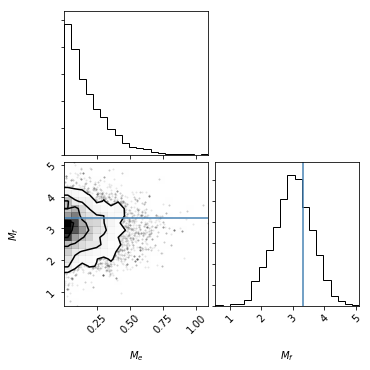

In [340]:
chains = sampler.flatchain
chains[:, :2] /= float(M_earth/M_sun)

corner(chains, truths=[mass_e/float(M_earth/M_sun), mass_f/float(M_earth/M_sun)], 
       labels=['$M_e$', '$M_f$']);
plt.savefig('ttv_recovery.png', bbox_inches='tight')